In [1]:
import cv2
import dlib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import psutil
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
YOLO_WEIGHTS = "/Users/vishaldutt/Downloads/M/yolov3.weights"
YOLO_CONFIG = "/Users/vishaldutt/Downloads/M/yolov3.cfg"

# Define paths to the model files
PREDICTOR_PATH = "/Users/vishaldutt/Downloads/M/shape_predictor_68_face_landmarks.dat"
CNN_FACE_DETECTOR_PATH = "/Users/vishaldutt/Downloads/M/mmod_human_face_detector.dat"


In [3]:
EAR_THRESHOLD = 0.2
FRAME_RATE = 1  # frames per second

In [4]:
ear_values = []  # To store (frame_number, EAR) tuples
blink_frames = []  # To store frames where blinks are detected
yawning_events = []  # To store tuples of (start_frame, end_frame) for yawning events
gaze_directions = []
landmark_movements = []  # Global list to store (frame_number, (x, y)) tuples for a landmark
object_detections = []  # To store (frame_number, object_class_id) tuples
processing_times = []  # To store processing time per frame
cpu_usage_percentages = []  # To store CPU usage percentages
memory_usages = []  # To store memory usage
true_labels = []  # True labels for your detections
predicted_labels = []  # Predicted labels by your system
results_df = pd.DataFrame(columns=['Frame_Number', 'Actual_Label', 'Predicted_Label'])

In [5]:
# Load YOLO
def load_yolo():
    net = cv2.dnn.readNet(YOLO_WEIGHTS, YOLO_CONFIG)
    layer_names = net.getLayerNames()

    # Check the structure of getUnconnectedOutLayers output
    unconnected_layers = net.getUnconnectedOutLayers()
    if unconnected_layers.ndim == 2:  # If it's 2D, it's likely an N x 1 matrix
        output_layers = [layer_names[i[0] - 1] for i in unconnected_layers]
    else:
        # Assume it's a flat array
        output_layers = [layer_names[i - 1] for i in unconnected_layers]

    return net, output_layers

In [6]:
# def is_mouth_open(shape):
#     # Nose tip and chin landmarks
#     nose_tip = shape[33]
#     chin = shape[8]

#     # Calculate the nose-to-chin distance
#     nose_to_chin_distance = np.linalg.norm(nose_tip - chin)

#     # Dynamic threshold - a percentage of the nose-to-chin distance
#     dynamic_threshold_percentage = 0.35  # 35% of the nose-to-chin distance
#     MOUTH_OPEN_THRESHOLD = dynamic_threshold_percentage * nose_to_chin_distance

#     # Mouth landmarks (indexes 48 to 68)
#     upper_lip = shape[50:53]
#     lower_lip = shape[56:59]

#     # Calculate the average points for upper and lower lips
#     upper_lip_avg = np.mean(upper_lip, axis=0)
#     lower_lip_avg = np.mean(lower_lip, axis=0)

#     # Calculate the distance between the averages
#     mouth_open_distance = np.linalg.norm(upper_lip_avg - lower_lip_avg)

#     return mouth_open_distance > MOUTH_OPEN_THRESHOLD

def is_mouth_open(shape):
    # Nose tip and chin landmarks
    nose_tip = shape[33]
    chin = shape[8]

    # Calculate the nose-to-chin distance
    nose_to_chin_distance = np.linalg.norm(nose_tip - chin)

    # Adjusted dynamic threshold for a wider opening detection
    dynamic_threshold_percentage = 0.35  # Consider tweaking based on further testing
    MOUTH_OPEN_THRESHOLD = dynamic_threshold_percentage * nose_to_chin_distance

    # Mouth landmarks for vertical distance
    upper_lip_top = shape[51]  # Top of the upper lip
    lower_lip_bottom = shape[57]  # Bottom of the lower lip

    # Vertical mouth open distance
    mouth_open_distance = np.linalg.norm(upper_lip_top - lower_lip_bottom)

    # Mouth landmarks for horizontal width (corners of the mouth)
    mouth_left_corner = shape[48]
    mouth_right_corner = shape[54]

    # Horizontal mouth width
    mouth_width = np.linalg.norm(mouth_left_corner - mouth_right_corner)

    # Calculate mouth aspect ratio (width/height)
    aspect_ratio = mouth_width / mouth_open_distance if mouth_open_distance != 0 else 0

    # Define a suitable aspect ratio range for speaking (example values, adjust based on observation)
    min_aspect_ratio = 1.5  # Minimum aspect ratio indicating more horizontal movement, adjust based on observation
    max_aspect_ratio = 2.5  # Maximum aspect ratio, adjust based on observation

    # Check if the mouth is widely open beyond the dynamic threshold and within a certain aspect ratio
    return mouth_open_distance > MOUTH_OPEN_THRESHOLD and min_aspect_ratio < aspect_ratio < max_aspect_ratio


In [7]:
def is_yawning(shape, frame_count, previous_opening, yawn_extent_threshold=25):
    global yawning_events
    upper_lip = shape[50:53]
    lower_lip = shape[56:59]

    upper_lip_avg = np.mean(upper_lip, axis=0)
    lower_lip_avg = np.mean(lower_lip, axis=0)
    distance = np.linalg.norm(upper_lip_avg - lower_lip_avg)
    if distance > yawn_extent_threshold:
        if 'start_frame' not in previous_opening:
            previous_opening['start_frame'] = frame_count
        elif frame_count - previous_opening['start_frame'] >= previous_opening.get('yawn_duration_threshold', 25):
            print(f"Yawning detected at frame {frame_count}")  # Debugging print
            previous_opening.clear()
            return True
    else:
        # If the mouth is now closed and a yawn was previously being tracked
        if 'start_frame' in previous_opening:
            # End the yawn event and record it
            end_frame = frame_count
            start_frame = previous_opening.pop('start_frame', None)
            if start_frame:
                yawning_events.append((start_frame, end_frame))

In [8]:
# Detection using YOLO
def detect_objects_yolo(frame, net, output_layers, frame_count):
    global object_detections
    height, width, _ = frame.shape
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)

    class_ids, confidences, boxes = [], [], []
    for output in outputs:
        for detect in output:
            scores = detect[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:  # Confidence threshold
                object_detections.append((frame_count, class_id))
                center_x = int(detect[0] * width)
                center_y = int(detect[1] * height)
                w = int(detect[2] * width)
                h = int(detect[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)  # Non-max suppression
    return indexes, boxes, class_ids


In [9]:
def draw_yolo_detections(frame, indexes, boxes, class_ids, ano):
    flag=0
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(class_ids[i])
            # Check if detected object is a cell phone; update 'cell_phone_class_id' with the actual ID
            cell_phone_class_id = 67  # Assuming 67 is the class ID for cell phones, adjust based on your model
            ear_phone_class_id = 81
            if int(label) == cell_phone_class_id:  
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(frame, "Cell Phone", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                print("Cell Phone Detected")
                ano=ano+1
            if int(label)== ear_phone_class_id:
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(frame, "Ear Phone", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                print("Cell Phone Detected")
                ano=ano+1


In [10]:
# DataFrame to store gaze data
gaze_data = pd.DataFrame(columns=["Frame", "Time", "Left_Gaze", "Right_Gaze"])

# Initialize dlib's face detector (CNN-based) and facial landmarks predictor
cnn_face_detector = dlib.cnn_face_detection_model_v1(CNN_FACE_DETECTOR_PATH)
predictor = dlib.shape_predictor(PREDICTOR_PATH)

In [11]:
def video_to_frames(video_path, frames_dir, frame_rate):
    if not os.path.exists(frames_dir):
        os.makedirs(frames_dir)

    vidcap = cv2.VideoCapture(video_path)
    if not vidcap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return

    fps = vidcap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps / frame_rate)

    success, image = vidcap.read()
    count = 0
    frame_count = 0

    while success:
        if count % frame_interval == 0:
            frame_file = os.path.join(frames_dir, f"frame_{frame_count}.jpg")
            cv2.imwrite(frame_file, image)
            frame_count += 1
        success, image = vidcap.read()
        count += 1

    vidcap.release()
    print(f"Extracted {frame_count} frames from {video_path}")

In [12]:
def detect_faces_cnn(frame):
    detected_faces = cnn_face_detector(frame, 1)
    return [d.rect for d in detected_faces]

In [13]:
def estimate_head_pose(frame, faces, predictor):
    """
    Estimates head pose based on detected faces and facial landmarks.

    :param frame: An image frame from a video (numpy array).
    :param faces: List of dlib rectangles representing detected face regions.
    :param predictor: Dlib's facial landmark predictor.
    :return: The frame with drawn head pose estimation.
    """
    # Define the 3D model points of facial landmarks in real-world coordinates
    model_points = np.array([
        (0.0, 0.0, 0.0),             # Nose tip
        (0.0, -330.0, -65.0),        # Chin
        (-225.0, 170.0, -135.0),     # Left corner of the left eye
        (225.0, 170.0, -135.0),      # Right corner of the right eye
        (-150.0, -150.0, -125.0),    # Left corner of the mouth
        (150.0, -150.0, -125.0)      # Right corner of the mouth
    ])

    # Camera internals (assuming a standard webcam)
    size = frame.shape
    focal_length = size[1]
    center = (size[1] / 2, size[0] / 2)
    camera_matrix = np.array(
        [[focal_length, 0, center[0]],
         [0, focal_length, center[1]],
         [0, 0, 1]], dtype="double"
    )

    for face in faces:
        # Convert face rectangle to bounding box coordinates
        x = face.left()
        y = face.top()
        w = face.right() - x
        h = face.bottom() - y

        # Get facial landmarks
        shape = predictor(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), face)
        image_points = np.array([
            (shape.part(30).x, shape.part(30).y),     # Nose tip
            (shape.part(8).x, shape.part(8).y),       # Chin
            (shape.part(36).x, shape.part(36).y),     # Left eye left corner
            (shape.part(45).x, shape.part(45).y),     # Right eye right corner
            (shape.part(48).x, shape.part(48).y),     # Left Mouth corner
            (shape.part(54).x, shape.part(54).y)      # Right mouth corner
        ], dtype="double")

        # Solve for pose
        (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, None, flags=cv2.SOLVEPNP_ITERATIVE)

        # Draw a 3D point to test the result (e.g., Nose tip)
        nose_tip_3D = np.array([(0, 0, 1000.0)], dtype="double")
        (nose_tip_2D, jacobian) = cv2.projectPoints(nose_tip_3D, rotation_vector, translation_vector, camera_matrix, None)
        p1 = (int(image_points[0][0]), int(image_points[0][1]))
        p2 = (int(nose_tip_2D[0][0][0]), int(nose_tip_2D[0][0][1]))
        cv2.line(frame, p1, p2, (255, 0, 0), 2)

    return frame

In [14]:
def detect_pupil(eye, frame):
    # Convert the eye landmarks into a NumPy array and find min/max coordinates
    eye_region = np.array(eye).astype(np.int32)
    min_x = np.min(eye_region[:, 0])
    max_x = np.max(eye_region[:, 0])
    min_y = np.min(eye_region[:, 1])
    max_y = np.max(eye_region[:, 1])

    # Extract the eye region from the frame
    eye_frame = frame[min_y:max_y, min_x:max_x]
    
    # Convert to grayscale and apply binary threshold inversion
    gray_eye = cv2.cvtColor(eye_frame, cv2.COLOR_BGR2GRAY)
    _, threshold_eye = cv2.threshold(gray_eye, 30, 255, cv2.THRESH_BINARY_INV)
    
    # Find contours in the thresholded eye frame
    contours, _ = cv2.findContours(threshold_eye, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours by area and attempt to detect the pupil
    contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
    for cnt in contours:
        # Get the bounding rectangle of the largest contour
        (x, y, w, h) = cv2.boundingRect(cnt)

        # Calculate the center of the pupil
        pupil_center_x = min_x + x + w // 2
        pupil_center_y = min_y + y + h // 2
        return (pupil_center_x, pupil_center_y)

    # Fallback if no pupil detected
    return (0, 0)

In [15]:
def eye_aspect_ratio(eye):
     # Compute the euclidean distances between the two sets of vertical eye landmarks (x, y)-coordinates
    A = np.linalg.norm(eye[1] - eye[5])
    B = np.linalg.norm(eye[2] - eye[4])

    # Compute the euclidean distance between the horizontal eye landmark (x, y)-coordinates
    C = np.linalg.norm(eye[0] - eye[3])

    # Compute the eye aspect ratio
    ear = (A + B) / (2.0 * C)
    return ear

In [16]:
def estimate_gaze_direction(eye, pupil):
    # Simple gaze direction estimation based on pupil position
    x_eye_center, y_eye_center = np.mean(eye, axis=0)
    x_pupil, y_pupil = pupil

    if abs(x_pupil - x_eye_center) > abs(y_pupil - y_eye_center):
        return "Looking Right" if x_pupil > x_eye_center else "Looking Left"
    else:
        return "Looking Up" if y_pupil < y_eye_center else "Looking Down"
ear_values = []

In [17]:
def localize_eye_regions_and_estimate_gaze(frame, faces, frame_count):
    """
    Localizes eye regions, detects pupils, and estimates gaze direction for each detected face.

    :param frame: An image frame from a video (numpy array).
    :param faces: List of dlib rectangles representing detected face regions.
    :param frame_count: Current frame count.
    :return: Modified frame with visualizations of eye regions and gaze direction.
    """
    global gaze_data, ear_values, blink_frames, landmark_movements
#     global ear_values

    for face in faces:
        # Extract eye regions
        shape = predictor(frame, face)
        left_eye = [(shape.part(i).x, shape.part(i).y) for i in range(36, 42)]
        right_eye = [(shape.part(i).x, shape.part(i).y) for i in range(42, 48)]

        # Detect pupils
        left_pupil = detect_pupil(left_eye, frame)
        right_pupil = detect_pupil(right_eye, frame)

        # Estimate gaze direction
        left_gaze = estimate_gaze_direction(left_eye, left_pupil)
        right_gaze = estimate_gaze_direction(right_eye, right_pupil)
        # Inside localize_eye_regions_and_estimate_gaze, after estimating gaze direction
        gaze_directions.append((frame_count, left_gaze))


        # Append gaze data to the DataFrame
        frame_data = {
            "Frame": frame_count,
            "Time": frame_count / FRAME_RATE,
            "Left_Gaze": left_gaze,
            "Right_Gaze": right_gaze
        }
        gaze_data = pd.concat([gaze_data, pd.DataFrame([frame_data])], ignore_index=True)
        cv2.polylines(frame, [np.array(left_eye, dtype=np.int32)], True, (0, 255, 0), 1)
        cv2.polylines(frame, [np.array(right_eye, dtype=np.int32)], True, (0, 255, 0), 1)
        cv2.circle(frame, left_pupil, 2, (0, 0, 255), -1)
        cv2.circle(frame, right_pupil, 2, (0, 0, 255), -1)
        shape = predictor(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), face)
        nose_tip = (shape.part(33).x, shape.part(33).y)
        landmark_movements.append((frame_count, nose_tip))
        left_eye_points = np.array([(shape.part(n).x, shape.part(n).y) for n in range(36, 42)], dtype='double')
        right_eye_points = np.array([(shape.part(n).x, shape.part(n).y) for n in range(42, 48)], dtype='double')
        
        left_ear = calculate_ear(left_eye_points)
        right_ear = calculate_ear(right_eye_points)
        avg_ear = (left_ear + right_ear) / 2.0
        ear_values.append((frame_count, avg_ear))
        
        if avg_ear<EAR_THRESHOLD:
            blink_frames.append(frame_count)

    return frame

In [18]:
def extract_frame_number(frame_file):
    try:
        # Assuming the filename format is 'frame_X.jpg' where X is the frame number
        return int(frame_file.split('_')[-1].split('.')[0])
    except ValueError:
        # Return None or a default value for files that don't match the expected format
        return None

In [19]:
# Anomaly detection function
def detect_anomalies(ano):
    global gaze_data
    # anomaly detection: prolonged off-screen gazes
    off_screen_duration_threshold = 0.01  # seconds
    anomalies = []
    off_screen_timer = 0
    last_gaze = "On-Screen"

    for index, row in gaze_data.iterrows():
        current_gaze = row["Left_Gaze"] if row["Left_Gaze"] == row["Right_Gaze"] else "On-Screen"
        if current_gaze == last_gaze and current_gaze != "On-Screen":
            off_screen_timer += 1 / frame_rate
            if off_screen_timer >= off_screen_duration_threshold:
                anomalies.append((row["Frame"], current_gaze))
        else:
            off_screen_timer = 0
            
        last_gaze = current_gaze
    ano += len(anomalies)
    decision = "Cheating Detected" if ano > 1 else "No Cheating Detected"
    return anomalies, decision
#     # Print anomalies
#     for anomaly in anomalies:
#         print(f"Anomaly detected at frame {anomaly[0]}: prolonged {anomaly[1]} gaze")
#         ano=ano+1
#     print(f"Total Anomalies:{ano}")
#     if ano>1:
#         print("System's Decision: Cheating Detected")
#     else:
#         print("System's Decision: No Cheating Detected")

In [20]:
def annotate_and_save_frames(anomalies):
    anomaly_frames = {frame: desc for frame, desc in anomalies}  # Create a dict for quick lookup

    for frame_file in sorted(os.listdir(frames_dir)):
        frame_number = extract_frame_number(frame_file)  # Implement this based on your filename format
        if frame_number in anomaly_frames:
            frame_path = os.path.join(frames_dir, frame_file)
            frame = cv2.imread(frame_path)
            
            # Annotate the frame with the detected anomaly
            anomaly_desc = anomaly_frames[frame_number]
            cv2.putText(frame, f"Anomaly: {anomaly_desc}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            
            # Save or display the annotated frame
            cv2.imwrite(os.path.join(frames_dir, "annotated_" + frame_file), frame)

In [21]:
def process_video(video_path, frames_dir, frame_rate, ano):
    # At the start of the process_video function
#     true_labels.append(actual_label)  # Add actual label for each frame or detection
#     predicted_labels.append(predicted_label)  # Add system's prediction for each frame or detection
    global object_detections
    net, output_layers = load_yolo()
    video_to_frames(video_path, frames_dir, frame_rate)

    frame_count = 0  # Initialize frame_count
    previous_opening = {}  # Initialize previous opening record for yawning detection
    start_time_overall = time.time()  # Start time for overall processing
    
    for frame_file in sorted(os.listdir(frames_dir)):
        if frame_file.endswith(".jpg"):
            start_time_frame = time.time()  # Start time for this frame
            frame_path = os.path.join(frames_dir, frame_file)
            frame = cv2.imread(frame_path)

            faces = detect_faces_cnn(frame)
            frame = estimate_head_pose(frame, faces, predictor)

            for face in faces:
                # Draw bounding box around the face
                cv2.rectangle(frame, (face.left(), face.top()), (face.right(), face.bottom()), (255, 0, 0), 2)
                shape = predictor(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), face)
                shape_np = np.array([[p.x, p.y] for p in shape.parts()])
                
                # Draw bounding box around the lips
                lips = shape_np[48:68]  # Lip landmarks
                min_x, min_y = np.min(lips, axis=0)
                max_x, max_y = np.max(lips, axis=0)
                cv2.rectangle(frame, (min_x, min_y), (max_x, max_y), (0, 255, 0), 2)
                # Draw the frame count on the frame
                cv2.putText(frame, f"Frame: {frame_count}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)


                # Yawning detection
                if is_yawning(shape_np, frame_count, previous_opening):
                    predicted_labels.append(2)
                    print(f"Yawning detected at frame {frame_count}")

                # Mouth open detection
                elif is_mouth_open(shape_np):
                    predicted_labels.append(1)
                    print(f"Anomaly detected at frame {frame_count}")
#                     cv2.putText(frame, f"Anomaly Detected", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
                    ano=ano+1;
#                     break;
                else:
                    predicted_labels.append(0)
            # Process for eye regions, gaze, and YOLO detection
            frame = localize_eye_regions_and_estimate_gaze(frame, faces, frame_count)
            indexes, boxes, class_ids = detect_objects_yolo(frame, net, output_layers, frame_count)
            draw_yolo_detections(frame, indexes, boxes, class_ids, ano)
            
            end_time_frame = time.time()  # End time for this frame
            processing_time = end_time_frame - start_time_frame
            processing_times.append(processing_time)
            
            cpu_usage = psutil.cpu_percent()
            cpu_usage_percentages.append(cpu_usage)
            
            memory_usage = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)  # Convert bytes to MB
            memory_usages.append(memory_usage)
            
            cv2.imwrite("processed_" + frame_file, frame)  # Save the frame
            cv2.imshow('Frame', frame)  # Display the frame
            cv2.waitKey(1)  # For continuous playback
            
            detect_objects_yolo(frame, net, output_layers, frame_count)
            frame_count += 1  # Increment frame_count

    cv2.destroyAllWindows()
    detect_anomalies(ano)  # Post-processing for anomaly detection
    end_time_overall = time.time()  # End time for overall processing
    total_processing_time = end_time_overall - start_time_overall
    print("Analysis Completed")
    print(f"Total processing time: {total_processing_time} seconds")
    

    # Visualization of performance metrics after the loop
    visualize_performance_metrics(processing_times, cpu_usage_percentages, memory_usages)

In [22]:
def visualize_performance_metrics(processing_times, cpu_usage_percentages, memory_usages):
    frames = range(1, len(processing_times) + 1)
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(3, 1, 1)
    plt.plot(frames, processing_times, label='Processing Time per Frame')
    plt.xlabel('Frame')
    plt.ylabel('Time (seconds)')
    plt.title('Processing Time per Frame')
    
    plt.subplot(3, 1, 2)
    plt.plot(frames, cpu_usage_percentages, label='CPU Usage (%)', color='orange')
    plt.xlabel('Frame')
    plt.ylabel('CPU Usage (%)')
    plt.title('CPU Usage Over Time')
    
    plt.subplot(3, 1, 3)
    plt.plot(frames, memory_usages, label='Memory Usage (MB)', color='green')
    plt.xlabel('Frame')
    plt.ylabel('Memory Usage (MB)')
    plt.title('Memory Usage Over Time')
    
    plt.tight_layout()
    plt.show()
#     # Calculate performance metrics
#     accuracy = accuracy_score(true_labels, predicted_labels)
#     precision = precision_score(true_labels, predicted_labels, average='binary')
#     recall = recall_score(true_labels, predicted_labels, average='binary')
#     f1 = f1_score(true_labels, predicted_labels, average='binary')

#     # Visualization for performance metrics
#     metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
#     values = [accuracy, precision, recall, f1]

#     plt.figure(figsize=(8, 5))
#     plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red'])
#     plt.xlabel('Metrics')
#     plt.ylabel('Scores')
#     plt.title('Performance Metrics')
#     plt.ylim(0, 1)  # Assuming the metrics values are between 0 and 1
#     plt.show()

In [23]:
def calculate_ear(eye_points):
    # Calculate the distances between the vertical eye landmarks
    A = np.linalg.norm(eye_points[1] - eye_points[5])
    B = np.linalg.norm(eye_points[2] - eye_points[4])
    
    # Calculate the distance between the horizontal eye landmarks
    C = np.linalg.norm(eye_points[0] - eye_points[3])
    
    # Calculate the EAR
    ear = (A + B) / (2.0 * C)
    return ear

In [24]:
def visualize_ear_over_time(ear_values):
    frame_numbers, ears = zip(*ear_values)  # Unzip frame numbers and EAR values
    plt.figure(figsize=(10, 6))
    plt.plot(frame_numbers, ears, '-o', color='blue')
    plt.title('Eye Aspect Ratio (EAR) Over Time')
    plt.xlabel('Frame Number')
    plt.ylabel('EAR')
    plt.show()

In [25]:
def visualize_ear_and_blinks(ear_values, blinks):
    frame_numbers, ears = zip(*ear_values)
    plt.plot(frame_numbers, ears, label='EAR')
    for blink_frame in blink_frames:
        plt.axvline(x=blink_frame, color='red', alpha=0.3, label='Blink')
    plt.title('EAR and Blinks Over Time')
    plt.xlabel('Frame')
    plt.ylabel('EAR')
    plt.legend()
    plt.show()

In [26]:
def visualize_object_detection_frequency(object_detections):
    frames = [frame for frame, _ in object_detections]
    plt.hist(frames, bins=max(frames), alpha=0.7)
    plt.title('Object Detection Frequency Over Time')
    plt.xlabel('Frame')
    plt.ylabel('Number of Detections')
    plt.show()

In [27]:
def analyze_gaze_direction(gaze_directions):
    # Extract gaze directions
    _, directions = zip(*gaze_directions)
    # Count the frequency of each direction
    direction_counts = Counter(directions)
    
    # Visualization
    plt.figure(figsize=(10, 6))
    plt.bar(direction_counts.keys(), direction_counts.values(), color='skyblue')
    plt.xlabel('Gaze Direction')
    plt.ylabel('Frequency')
    plt.title('Gaze Direction Analysis')
    plt.show()

In [28]:
def visualize_yawning_events(yawning_events):
    plt.figure(figsize=(10, 6))
    for start, end in yawning_events:
        plt.axvline(x=start, color='r', linestyle='--', label='Yawn Start')
        plt.axvline(x=end, color='g', linestyle='--', label='Yawn End')
    plt.title('Yawning Events Over Time')
    plt.xlabel('Frame')
    plt.ylabel('Event Presence')
    plt.legend()
    plt.show()

In [29]:
def visualize_landmark_movement(landmark_movements, landmark_index=33):
    """Visualize movement of a specified landmark over time."""
    frames, positions = zip(*landmark_movements)
    x_positions = [pos[0] for pos in positions]
    y_positions = [pos[1] for pos in positions]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(frames, x_positions, label='X Position')
    plt.title(f'Landmark {landmark_index} X Movement')
    plt.xlabel('Frame')
    plt.ylabel('X Position')

    plt.subplot(1, 2, 2)
    plt.plot(frames, y_positions, label='Y Position')
    plt.title(f'Landmark {landmark_index} Y Movement')
    plt.xlabel('Frame')
    plt.ylabel('Y Position')

    plt.tight_layout()
    plt.show()

Extracted 9 frames from /Users/vishaldutt/Downloads/M/Vid_2.mov
Analysis Completed
Total processing time: 96.96691489219666 seconds


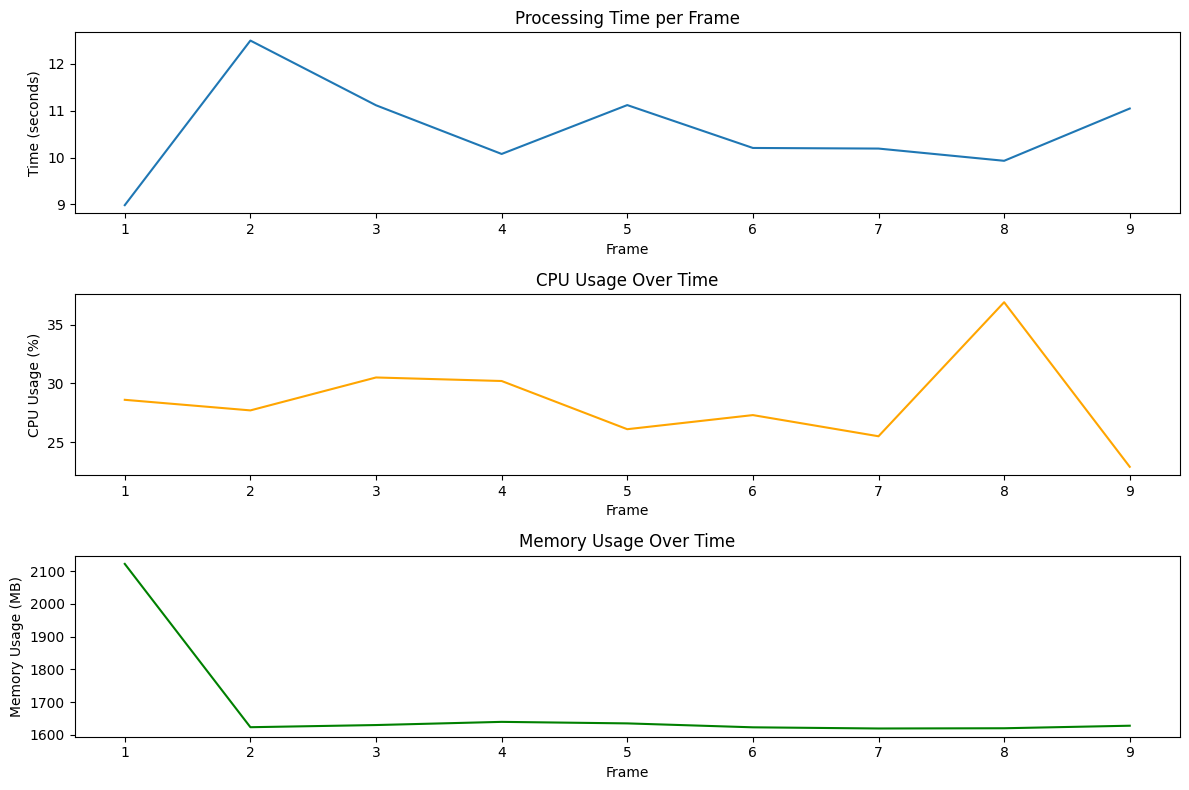

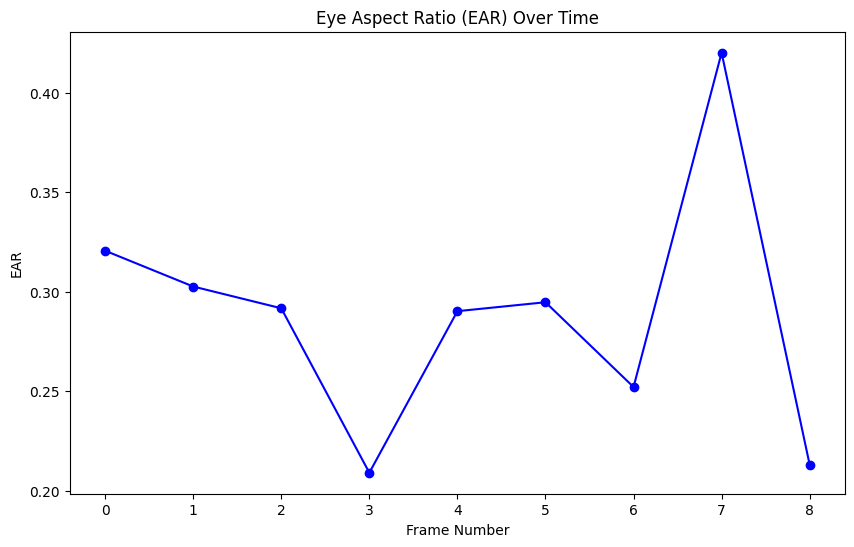

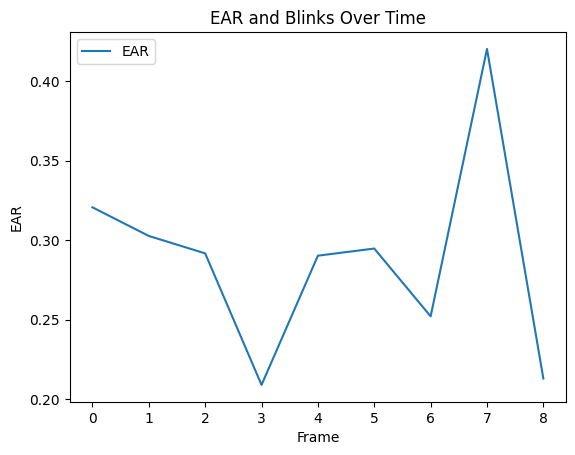

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


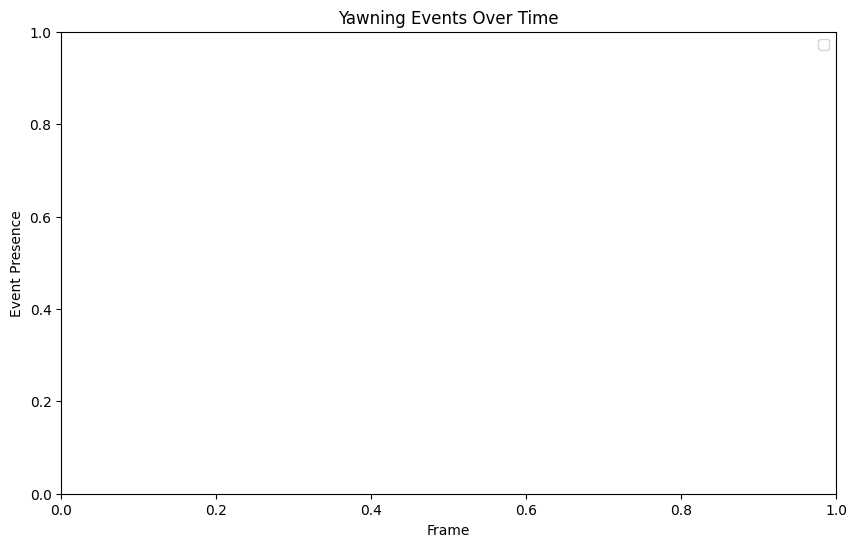

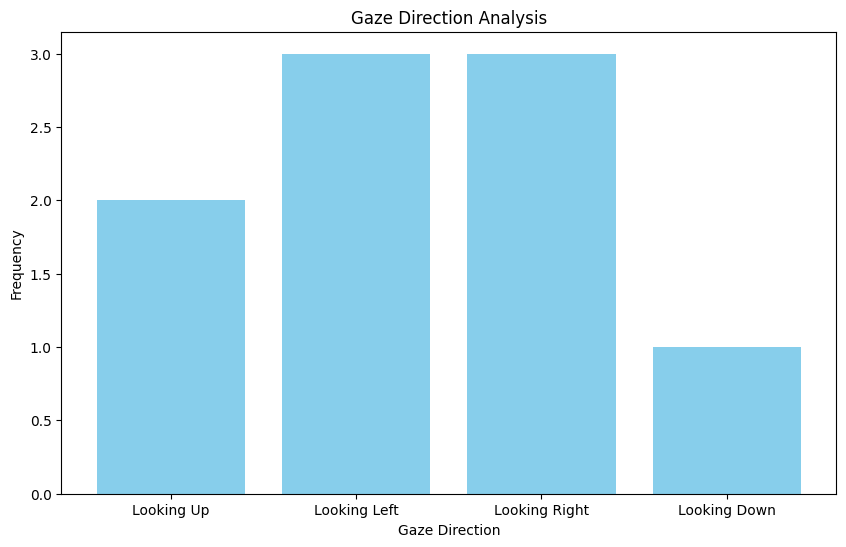

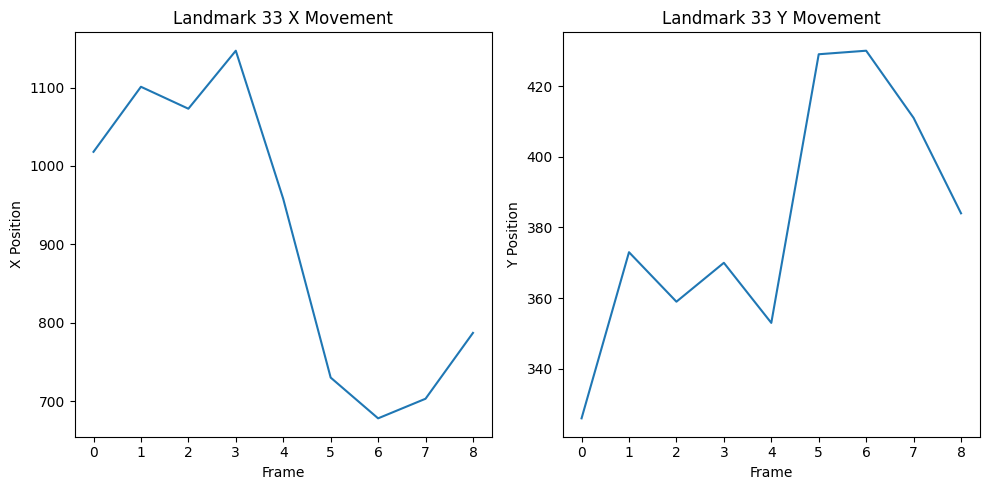

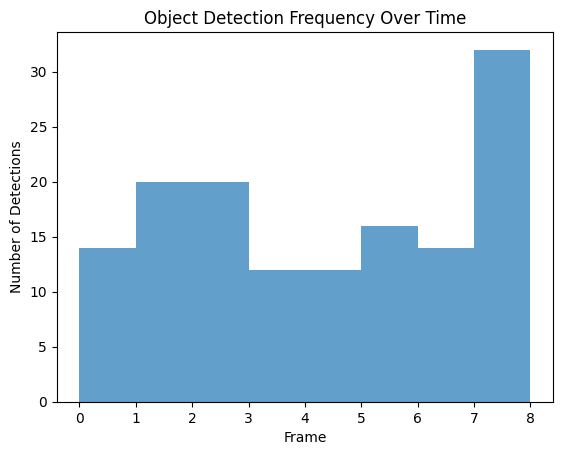

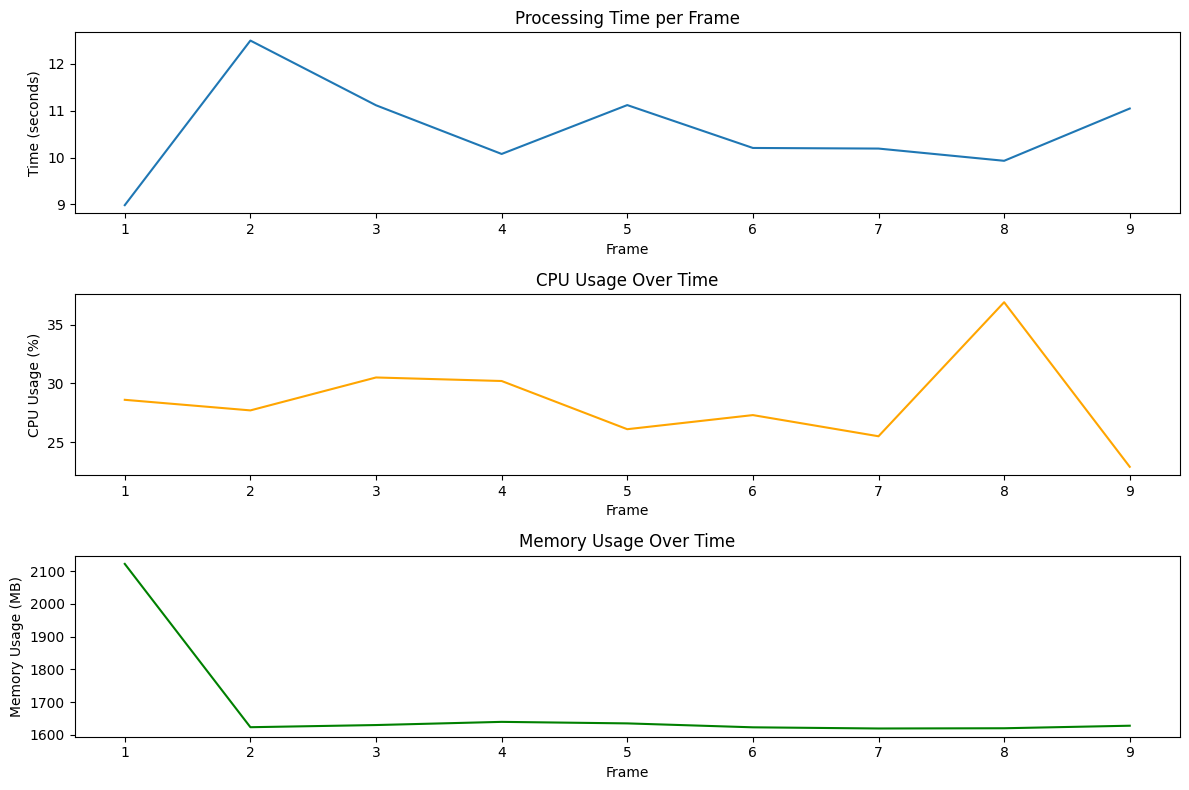

In [30]:
# Usage
if __name__ == "__main__":
    ano=0
    video_path = '/Users/vishaldutt/Downloads/M/Vid_2.mov'  # Replace with your video path
    frames_dir = '/Users/vishaldutt/Downloads/M/imgdir'  # Folder where frames will be saved
    frame_rate = 1  # Extract 1 frame per second

    process_video(video_path, frames_dir, frame_rate, ano)
    visualize_ear_over_time(ear_values)
    visualize_ear_and_blinks(ear_values, blink_frames)
    visualize_yawning_events(yawning_events)
    analyze_gaze_direction(gaze_directions)
    visualize_landmark_movement(landmark_movements, 33)  # Assuming 33 is the nose tip landmark
    visualize_object_detection_frequency(object_detections)
    visualize_performance_metrics(processing_times, cpu_usage_percentages, memory_usages)